<a href="https://colab.research.google.com/github/bonareri/Bitcoin-Prediction-Analysis/blob/main/arima_sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ARIMA

:ARIMA (AutoRegressive Integrated Moving Average) model predicts future values based on historical data. It has three main components:

1. AR (AutoRegressive): Uses past values to predict the future.
2. I (Integrated): The differencing of raw observations to make the time series stationary.
3. MA (Moving Average): Uses past errors to predict the future. Best for stationary series

Key Parameters of ARIMA

- p: Number of past values (lags).
- d: Degree of differencing (to make data stationary).
- q: Moving average window size.

## 1. Data Collection

### Install packages

In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.0 MB/s eta 0:00:00


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import random
import statsmodels.api as sm
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")  # Ignore warnings

# Import necessary libraries
import pandas as pd                # For data handling
import numpy as np                 # For numerical computations
import matplotlib.pyplot as plt    # For plotting
import seaborn as sns             # For advanced plotting
from datetime import datetime      # For handling date and time

# ARIMA and SARIMA models
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA     # ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # SARIMA model

# Time series tools
from statsmodels.tsa.stattools import adfuller      # For Augmented Dickey-Fuller test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For ACF and PACF plots
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose

# Model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error   # For model performance evaluation

### Load the data

In [3]:
# Load preprocessed data
df = pd.read_csv('/content/bitcoin_prices_preprocessed.csv')

# Display the first few rows of the data
df.head()

,Date,Open,High,Low,Close,Volume,Daily_Return,MA7,MA30
0,2015-03-07,272.294006,277.854004,270.132996,276.260986,17825900,0.012973,273.689715,244.523235
1,2015-03-08,276.433014,277.858002,272.565002,274.354004,22067900,-0.006903,275.711430,246.259502
2,2015-03-09,274.812012,292.700989,273.893005,289.606995,59178200,0.055596,277.702427,248.321268
3,2015-03-10,289.862000,300.044006,289.743011,291.760010,67770800,0.007434,279.139287,250.599535
4,2015-03-11,291.524994,297.390991,290.507996,296.378998,33963900,0.015831,282.465999,253.141835


## 2. Data Preprocessing

In [4]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime format
df.set_index('Date', inplace=True)  # Set as index

### 2.1 Visualizing the Data

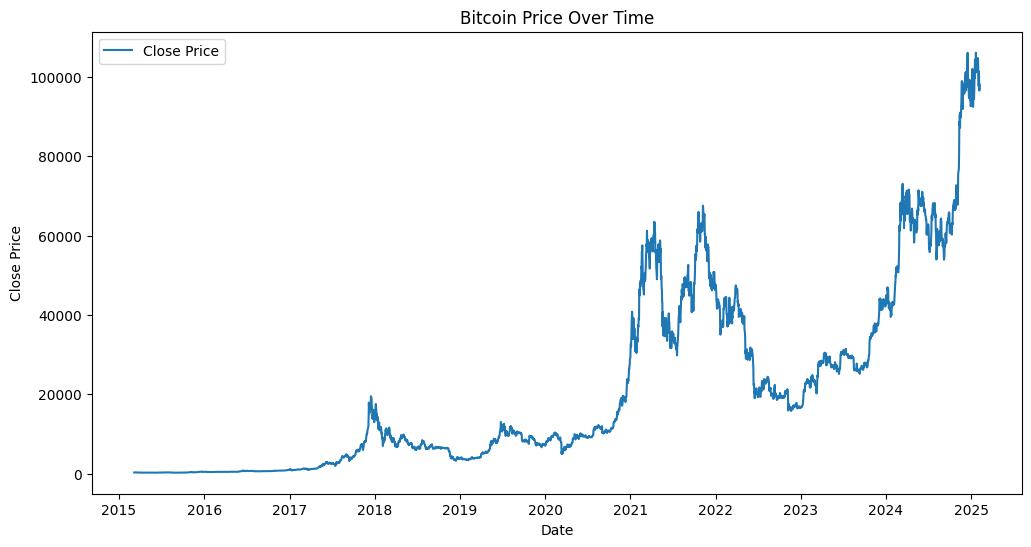

In [7]:
# Plotting the original Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Close"], label='Close Price')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

### 2. Checking for Stationarity

#### Visual Inspection (Rolling Mean & Standard Deviation)

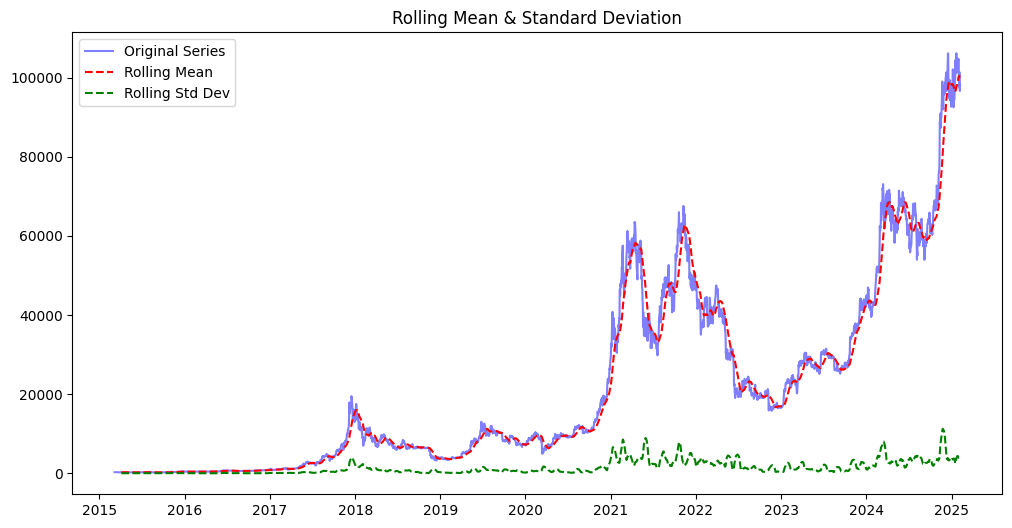

In [ ]:
def plot_rolling_statistics(series, window=30):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label="Original Series", color="blue", alpha=0.5)
    plt.plot(rolling_mean, label="Rolling Mean", color="red", linestyle="dashed")
    plt.plot(rolling_std, label="Rolling Std Dev", color="green", linestyle="dashed")
    plt.legend()
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

# Apply on 'Close' column
plot_rolling_statistics(df['Close'])

The rolling mean and standard deviation fluctuate over time, the data is likely non-stationary.

#### Augmented Dickey-Fuller (ADF) Test:

In [5]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(df["Close"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

ADF Statistic (Original): 0.3423
p-value (Original): 0.9792
Interpretation: The original series is Non-Stationary.



### 2.2 Log Transformation

The Bitcoin price data exhibits an **exponential-like growth**, with prolonged periods of relatively low values followed by sharp increases. This results in **high variance**, making trend analysis difficult.  

To address this, I applied a **log transformation** (`log(price)`) for the following reasons:  

**Benefits of Log Transformation**  

- **Stabilizing Variance** 📉: The original data shows large fluctuations, especially in later years. Log transformation helps **normalize these variations**.  
- **Enhancing Trend Visibility** 📊: Without transformation, the earlier values appear almost flat compared to later spikes. Log transformation allows for a **clearer view of long-term trends**.  
- **Reducing the Impact of Outliers** ⚠️: Extreme price spikes dominate the scale in the original data. Applying a log transformation **compresses these values**, making patterns in the data more apparent.  

---



In [7]:
# Apply log transformation
df['Log_Close'] = np.log(df['Close'])

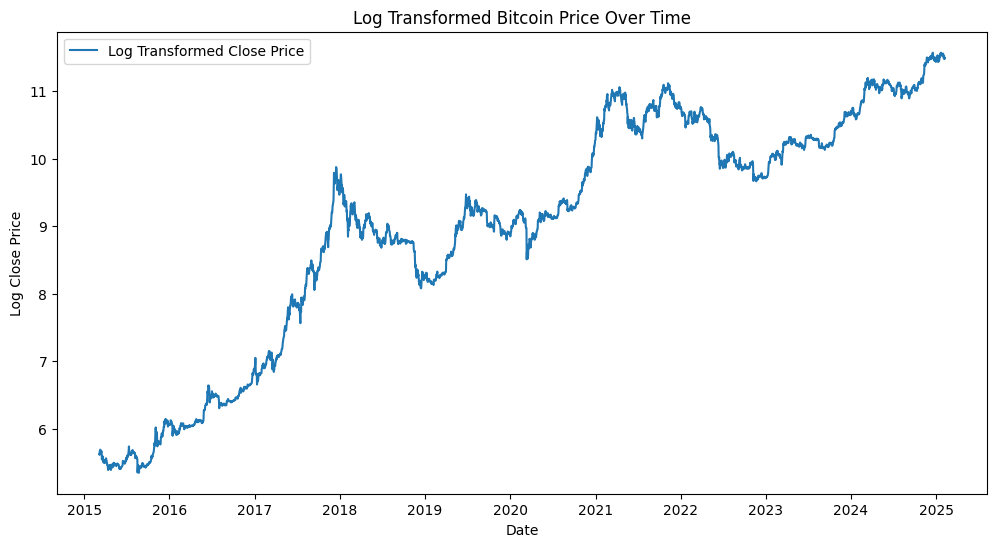

In [8]:
# Plotting the log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(df['Log_Close'], label='Log Transformed Close Price')
plt.title('Log Transformed Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Log Close Price')
plt.legend()
plt.show()

### 3.Differencing to Achieve Stationarity

In [9]:
# Apply first-order differencing to the log-transformed data
df['Log_Close_Diff'] = df['Log_Close'].diff()

In [10]:
# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(df["Log_Close_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -42.0864
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


###  Visualizing the Differenced Data

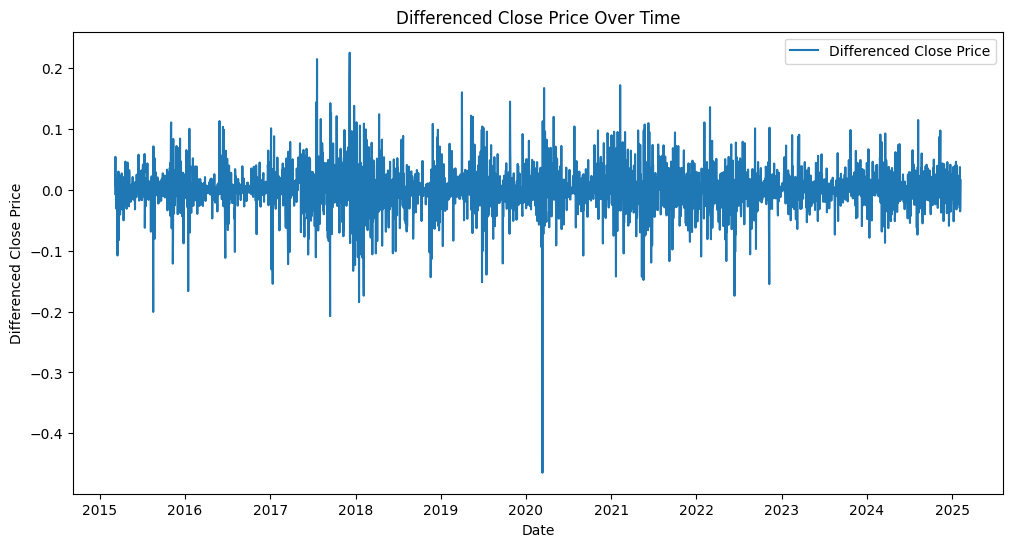

In [11]:
# Plotting the differenced Close price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Log_Close_Diff'], label='Differenced Close Price')
plt.title('Differenced Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.legend()
plt.show()

**Stationarity Check Insights**
- Initially, the **Augmented Dickey-Fuller (ADF) test** showed that the series was **non-stationary** (p-value = 0.986).
- After **first-order differencing**, the ADF test confirmed that the series is now **stationary** (ADF Statistic = -9.206, p-value < 0.05).
- This means the differencing step successfully removed trend-related non-stationarity.

### 4. Checking for seasonality using seasonal decomposition


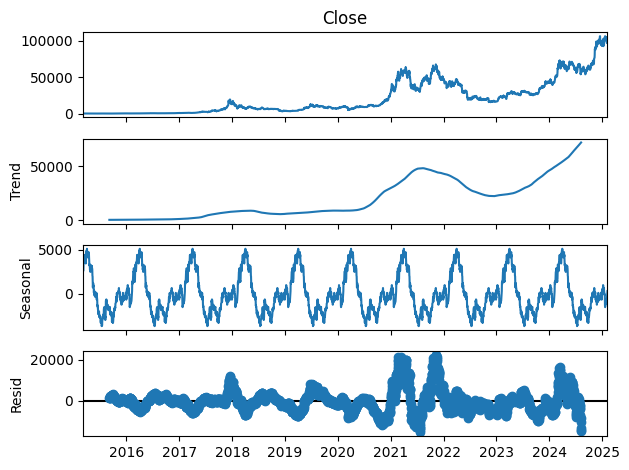

In [12]:
decomposition = seasonal_decompose(df['Close'], model='additive', period=365)
decomposition.plot()
plt.show()

### Interpretation of the Components

**1️⃣ Original Time Series (Top Panel: "Close")**
- The Bitcoin price follows an exponential growth pattern with large fluctuations.  
- This confirms the need for log transformation or differencing to stabilize variance.  

**2️⃣ Trend Component**  
- There's a clear upward trend with some flattening and dips (e.g., around 2021–2022).  
- This suggests that differencing was needed to remove the trend for ARIMA modeling.  

**3️⃣ Seasonal Component**
- There is a strong seasonal pattern, repeating consistently every year.  
- This suggests that SARIMA (Seasonal ARIMA) might be a better choice than ARIMA.  
- You should determine the seasonal period (e.g., 365 for daily data, 52 for weekly data).  

**4️⃣ Residual Component**
- The residuals appear to be somewhat stationary, meaning differencing removed most trends.  
- However, variance increases around 2021-2022, which might indicate volatility clustering.  


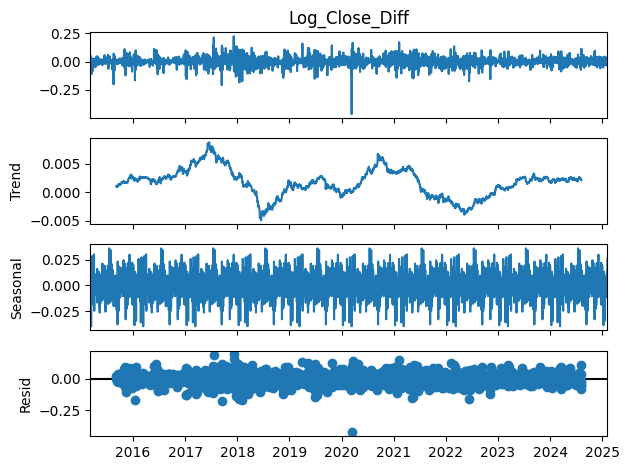

In [14]:
decomposition = seasonal_decompose(df["Log_Close_Diff"].dropna(), model="additive", period=365)
decomposition.plot()
plt.show()

### Interpretation of the Log-Transformed & Differenced Decomposition  

**1️⃣ Transformed Time Series (Top Panel: "Log_Close_Diff")**  
- The original exponential trend has been **removed**, making fluctuations more stable.  
- Differencing has eliminated the strong upward trend, helping make the series **more stationary**.  
- However, some **volatility spikes remain**, indicating that further modeling may be required.  

**2️⃣ Trend Component**  
- The trend is now more **stable**, with gradual fluctuations instead of exponential growth.  
- The downward movement around **2021–2022** aligns with market corrections.  
- This suggests that **differencing was effective** but still retains some underlying structure.  

**3️⃣ Seasonal Component**  
- A **repeating pattern** is visible, meaning seasonality is still present even after transformation.  
- This suggests that **SARIMA (Seasonal ARIMA) may be preferable** over standard ARIMA.  
- The periodic nature (possibly **weekly, monthly, or yearly**) should be analyzed further using ACF/PACF plots.  

**4️⃣ Residual Component**  
- Residuals look **more stationary**, meaning most trends and seasonality have been removed.  
- However, **volatility clustering** is noticeable, especially around **2021–2022**, which could indicate:  
  - A need for **GARCH modeling** if volatility is important.  
  - Potential **structural breaks** in the data that need further investigation.  



### 5. Visualize Autocorrelations and Partial Autocorrelations

For ARIMA and SARIMA, the ACF plot helps determine the MA (Moving Average) term, while the PACF plot helps determine the AR (Auto-Regressive) term.

#### Determine (p, d, q) using ACF & PACF

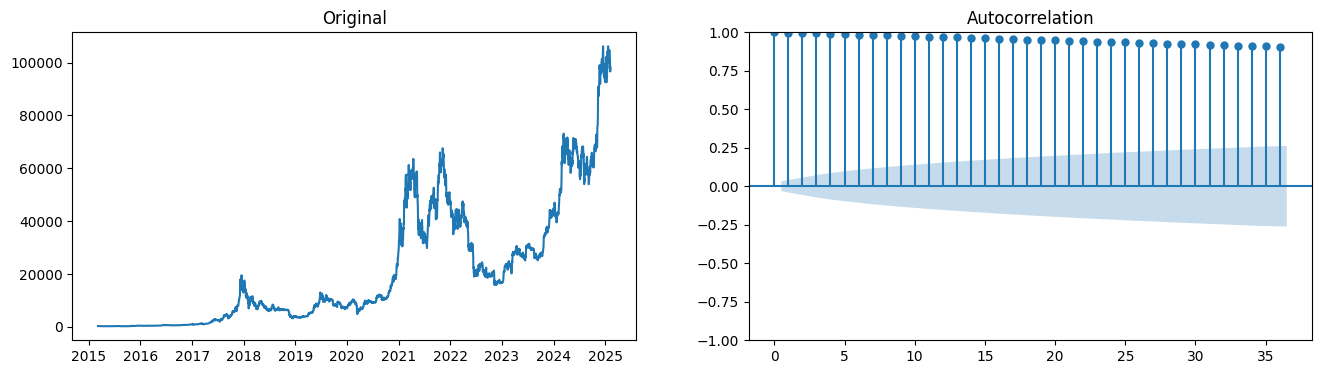

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(df.Close)
ax1.set_title('Original')
plot_acf(df.Close, ax=ax2)
ax2.set_title('Autocorrelation')

plt.show()

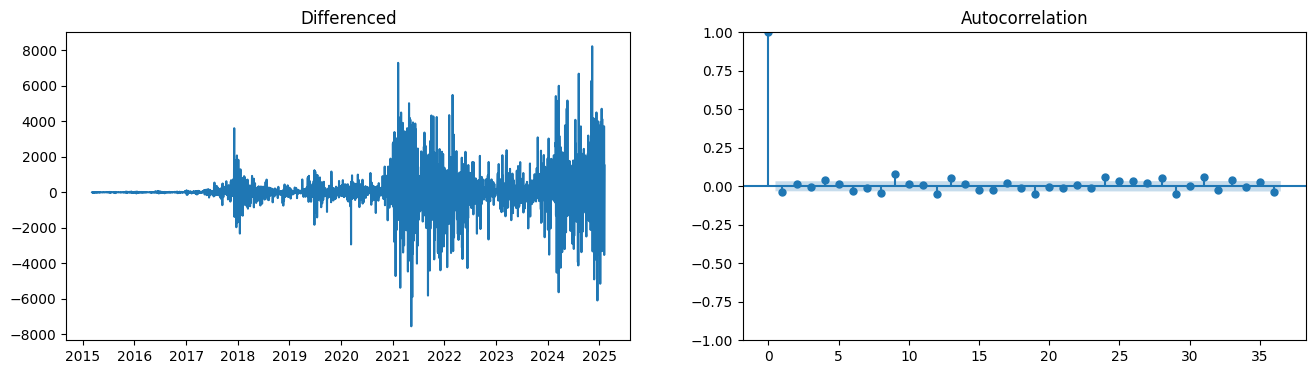

In [14]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_acf(diff, ax=ax2);

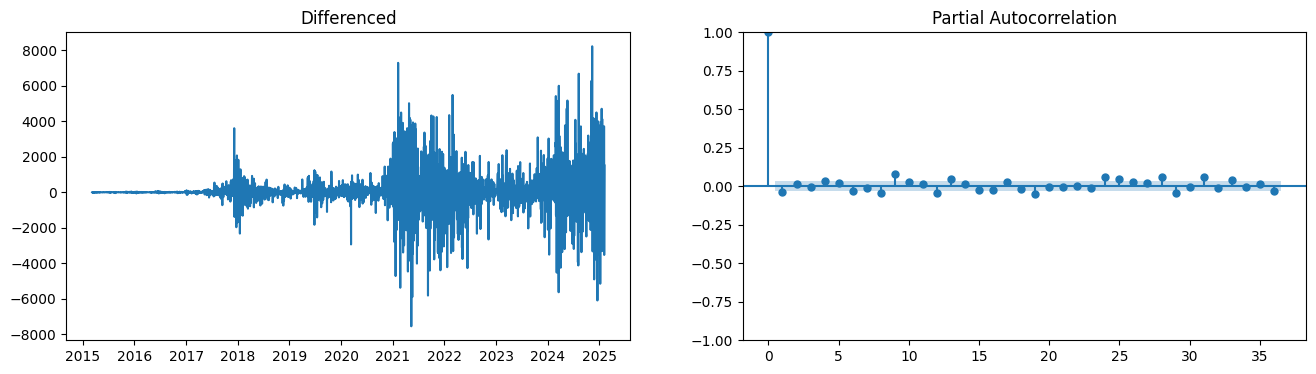

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title('Differenced')
plot_pacf(diff, ax=ax2);

**Analysis from ACF and PACF**  

- **ACF** shows a sharp drop after lag 1 → suggests **MA(1)** (Moving Average order = 1).  
- **PACF** cuts off after lag 1 → suggests **AR(1)** (Autoregressive order = 1).  
- The data has been differenced and confirmed to be stationary (**ADF test p-value < 0.05**), meaning **first-order differencing (d = 1) was required**.  

**ARIMA Model: ARIMA(1,1,1)**  
- **p = 1** (Autoregressive component from PACF)  
- **d = 1** (First-order differencing to ensure stationarity)  
- **q = 1** (Moving Average component from ACF)  

Since differencing was required to make the data stationary, an **ARIMA(1,1,1) model** is the best fit instead of ARMA(1,1), which is used for already stationary series (**d = 0**).


## Split Data into Train and Test

In [15]:
# Split data (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Print sizes
print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 2900, Test size: 725


## Model Selection and Fitting (ARIMA/SARIMA)

### ARIMA Model:

In [16]:
# Set frequency to daily ('D') or the appropriate frequency based on your data
df = df.asfreq('D')

In [17]:
# Define ARIMA model with determined p, d, q
model = ARIMA(train['Log_Close'], order=(1, 0, 1))  # p=1, d=0, q=1
model_fit = model.fit()

In [18]:
#print summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Log_Close   No. Observations:                 2900
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5355.734
Date:                Sat, 08 Feb 2025   AIC                         -10703.468
Time:                        07:28:08   BIC                         -10679.578
Sample:                    03-07-2015   HQIC                        -10694.860
                         - 02-12-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5522      0.690     12.392      0.000       7.200       9.905
ar.L1          0.9994      0.000   2988.507      0.000       0.999       1.000
ma.L1         -0.0224      0.013     -1.788      0.0

### Key Takeaways

- **AR(1) coefficient (0.9994):** Strong positive influence of past values on future values (**P>|z| = 0.000**, statistically significant).  
- **MA(1) coefficient (-0.0224):** Minimal negative effect of past errors on the current value (**P>|z| = 0.074**, not statistically significant).  
- **sigma² (variance of residuals):** Very small (**0.0015**), indicating a well-fitted model.  

**Diagnostic Tests**

- **Ljung-Box Test (Q-statistic):** 0.01 (**Prob = 0.94**) → No autocorrelation in residuals (**good sign**).  
- **Jarque-Bera (JB) Test:** 15984.68 (**Prob = 0.00**) → Residuals are **not normally distributed**.  
- **Heteroskedasticity Test (H):** 1.10 (**Prob = 0.14**) → No significant heteroskedasticity (**variance is stable**).  
- **Skewness (-0.76):** Residuals are slightly left-skewed.  
- **Kurtosis (14.40):** High kurtosis suggests heavy tails (**outliers present**).  

**Summary**

- The **AR(1) coefficient is highly significant**, indicating strong autocorrelation. However, the **MA(1) coefficient is not statistically significant**.  
- The **residuals are not normally distributed**, but the model does not suffer from **autocorrelation or heteroskedasticity**.  
- The **AIC is very low (-10703.468)**, suggesting a **good model fit**.  

**Possible Improvements**

- **Using SARIMA** (seasonal components) since the data has a seasonal pattern.  
- **Increasing MA orders** or adjusting differencing (**d**) for potential improvements.  
- **Checking residual plots** for further insights.




### Forecast on Test Data

In [19]:
# Forecast on test set
forecast = model_fit.forecast(steps=len(test))

In [21]:
# Convert back from log scale (inverse transformation)
test['Predicted_Close'] = np.exp(forecast)

In [22]:
# Get the last actual value from the training set
last_train_value = train['Close'].iloc[-1]

# Reverse differencing by cumulatively summing the forecasted values
test['Predicted_Close'] = np.cumsum(forecast) + last_train_value

In [23]:
# Print first few predictions
print(test[['Close', 'Predicted_Close']].tail())

                    Close  Predicted_Close
Date                                      
2025-02-02   97688.976562     28786.037458
2025-02-03  101405.421875     28795.499766
2025-02-04   97871.820312     28804.961499
2025-02-05   96615.445312     28814.422657
2025-02-06   98125.453125     28823.883240


### Plot Actual vs Predicted Prices

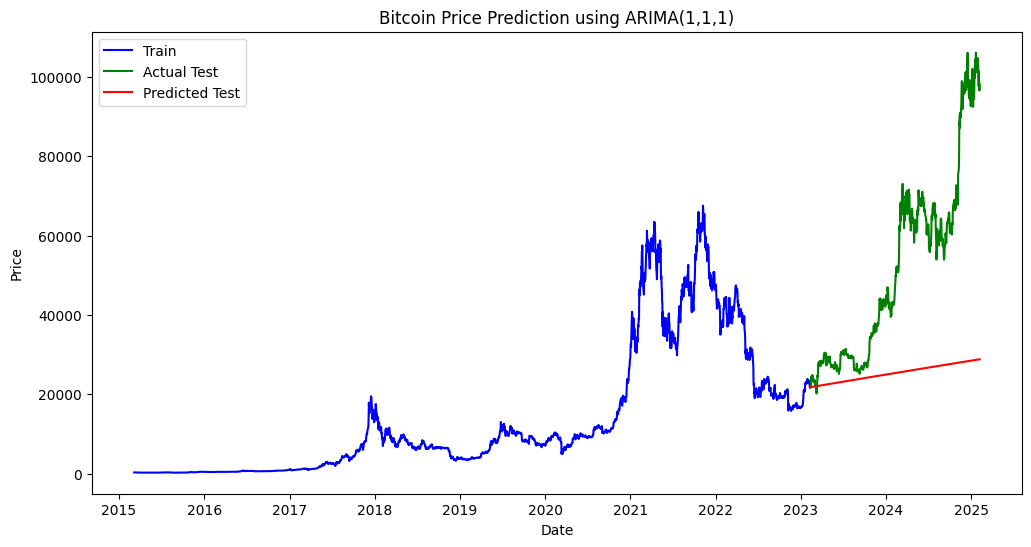

In [24]:
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close'], label="Predicted Test", color='red')
plt.title("Bitcoin Price Prediction using ARIMA(1,1,1)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

###  Evaluate the Model

In [25]:
# Check for NaN values in 'Predicted_Close' and remove rows where it's NaN
test_cleaned = test.dropna(subset=['Predicted_Close'])

# Compute error metrics only if 'Predicted_Close' is populated
mae = mean_absolute_error(test_cleaned['Close'], test_cleaned['Predicted_Close'])
mse = mean_squared_error(test_cleaned['Close'], test_cleaned['Predicted_Close'])
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 26351.70
MSE: 1163154543.18
RMSE: 34105.05


## SARIMA

**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing **

Extends ARIMA by adding seasonal components:
Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [26]:
# Define the SARIMA model with seasonal order
sarima_model = SARIMAX(train['Log_Close'],
                       order=(1, 0, 1),  # (p, d, q) non-seasonal order
                       seasonal_order=(1, 0, 1, 12),  # (P, D, Q, s) seasonal order with period=12 (monthly seasonality)
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [27]:
# Fit the model
sarima_fit = sarima_model.fit(disp=False)

In [28]:
#summary statistics
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Log_Close   No. Observations:                 2900
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                5334.656
Date:                            Sat, 08 Feb 2025   AIC                         -10659.312
Time:                                    07:31:16   BIC                         -10629.474
Sample:                                03-07-2015   HQIC                        -10648.558
                                     - 02-12-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0001   7.93e-05   1.26e+04      0.000       1.000       1.000
ma.L1         -0.0124      0.012   

### Key Takeaways

- **AR(1) coefficient (1.0001):** Strong positive influence of past values on future values (**P>|z| = 0.000**, statistically significant).  
- **MA(1) coefficient (-0.0125):** Small negative effect of past errors on the current value (**P>|z| = 0.315**, not statistically significant).  
- **Seasonal AR(12) coefficient (0.4002):** Suggests some seasonal dependency (**P>|z| = 0.080**, marginally significant).  
- **Seasonal MA(12) coefficient (-2.4649):** Strong negative seasonal effect (**P>|z| = 0.076**, marginally significant).  
- **sigma² (variance of residuals):** Very small (**0.0002**), indicating a well-fitted model.  

**Diagnostic Tests**

- **Ljung-Box Test (Q-statistic):** 0.43 (**Prob = 0.51**) → No autocorrelation in residuals (**good sign**).  
- **Jarque-Bera (JB) Test:** 16019.38 (**Prob = 0.00**) → Residuals are **not normally distributed**.  
- **Heteroskedasticity Test (H):** 1.11 (**Prob = 0.11**) → No significant heteroskedasticity (**variance is stable**).  
- **Skewness (-0.77):** Residuals are slightly left-skewed.  
- **Kurtosis (14.44):** High kurtosis suggests heavy tails (**outliers present**).  

**Summary**  

- The **AR(1) coefficient is highly significant**, indicating strong autocorrelation. However, the **MA(1) coefficient is not statistically significant**.  
- The **seasonal AR and MA components show some significance**, suggesting seasonality should be considered.  
- The **residuals are not normally distributed**, but the model does not suffer from **autocorrelation or heteroskedasticity**.  
- The **AIC is very low (-10659.313)**, suggesting a **good model fit**.  

**Possible Improvements**

- **Refining the seasonal component** by adjusting SARIMA orders.  
- **Increasing MA orders** or adjusting differencing (**d**) for potential improvements.  
- **Checking residual plots** for further insights.




### Forecasting:

In [29]:
# Forecast the test set
forecast_sarima = sarima_fit.forecast(steps=len(test))

In [30]:
# Convert back from log scale (inverse transformation)
test['Predicted_Close_SARIMA'] = np.exp(forecast_sarima)

In [31]:
# Reverse differencing using the last actual value from the training set
last_train_value = train['Close'].iloc[-1]

# Undo differencing by cumulatively summing
test['Predicted_Close'] = np.cumsum(forecast_sarima) + np.log(last_train_value)

# Convert back from log scale
test['Predicted_Close'] = np.exp(test['Predicted_Close'])

In [32]:
# Calculate MAE, MSE, RMSE based on the actual and predicted prices
mae_sarima = mean_absolute_error(test['Close'], test['Predicted_Close_SARIMA'])
mse_sarima = mean_squared_error(test['Close'], test['Predicted_Close_SARIMA'])
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA MAE: {mae_sarima:.2f}")
print(f"SARIMA MSE: {mse_sarima:.2f}")
print(f"SARIMA RMSE: {rmse_sarima:.2f}")

SARIMA MAE: 13375.73
SARIMA MSE: 328949464.75
SARIMA RMSE: 18136.96


### Plot Forecasts

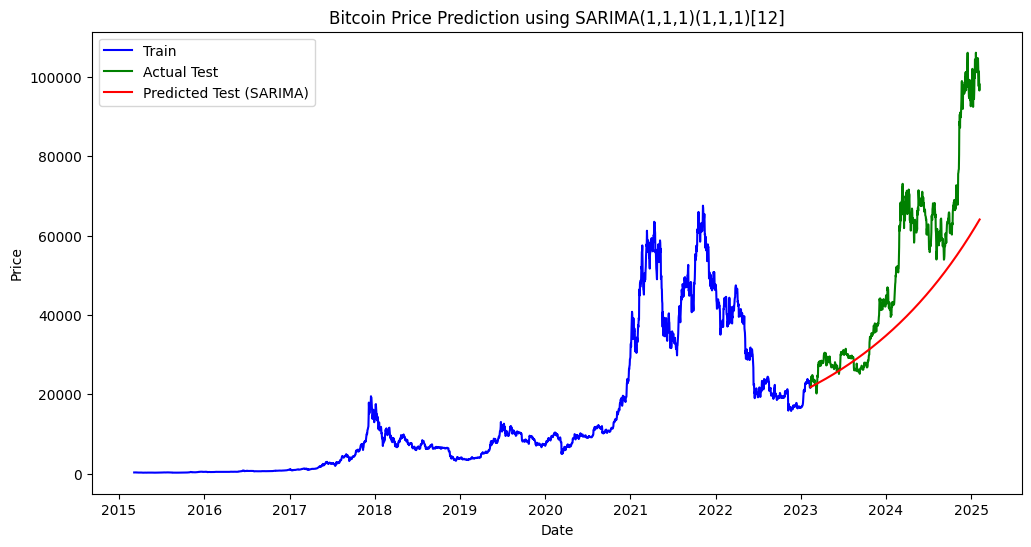

In [33]:
# Plot the results
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close_SARIMA'], label="Predicted Test (SARIMA)", color='red')
plt.title("Bitcoin Price Prediction using SARIMA(1,1,1)(1,1,1)[12]")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

## Hyperparameter Tuning

### Auto ARIMA for Best Parameters

In [34]:
# Use only the last 1000 data points for training
train_sample = train['Log_Close'].iloc[-1000:]

# Fit Auto ARIMA model
auto_model = pm.auto_arima(train_sample,
                           seasonal=True,
                           m=12,  # Seasonal period (monthly data)
                           stepwise=True,
                           trace=True,
                           suppress_warnings=True,
                           max_p=3, max_q=3,  # Limits to speed up execution
                           max_P=2, max_Q=2,
                           max_d=2, max_D=2)

# Print the best model summary
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=inf, Time=3.11 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-3111.440, Time=0.09 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-3427.074, Time=0.29 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=1.17 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-3428.605, Time=0.14 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=-3427.005, Time=1.39 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=-3430.902, Time=1.93 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=-3434.610, Time=2.51 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=-3432.438, Time=1.14 sec
 ARIMA(1,2,0)(2,0,2)[12]             : AIC=-3439.623, Time=4.56 sec
 ARIMA(1,2,0)(1,0,2)[12]             : AIC=-3435.271, Time=4.67 sec
 ARIMA(0,2,0)(2,0,2)[12]             : AIC=-3131.249, Time=4.15 sec
 ARIMA(2,2,0)(2,0,2)[12]             : AIC=-3563.255, Time=4.42 sec
 ARIMA(2,2,0)(1,0,2)[12]             : AIC=-3561.089, Time=4.99 sec
 ARIMA(2,2,0)(2,0

In [35]:
# Forecast for the test set
forecast_sarima = auto_model.predict(steps=len(test))

# Convert back to the original price scale (since we modeled log prices)
test['Predicted_Close'] = np.exp(forecast_sarima)

# Remove any infinite values
test['Predicted_Close'] = test['Predicted_Close'].replace([np.inf, -np.inf], np.nan)
test.dropna(subset=['Predicted_Close'], inplace=True)

In [36]:
# Calculate error metrics
mae_sarima = mean_absolute_error(test['Close'], test['Predicted_Close'])
mse_sarima = mean_squared_error(test['Close'], test['Predicted_Close'])
rmse_sarima = np.sqrt(mse_sarima)

print(f"Tuned SARIMA MAE: {mae_sarima:.2f}")
print(f"Tuned SARIMA MSE: {mse_sarima:.2f}")
print(f"Tuned SARIMA RMSE: {rmse_sarima:.2f}")

Tuned SARIMA MAE: 2771.77
Tuned SARIMA MSE: 9278739.47
Tuned SARIMA RMSE: 3046.10


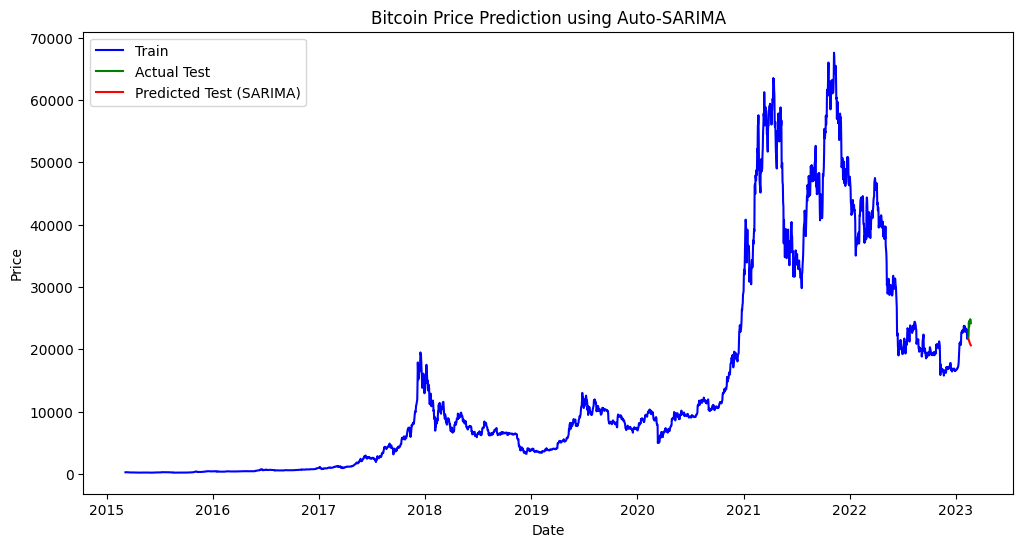

In [37]:
plt.figure(figsize=(12,6))
plt.plot(train.index, np.exp(train['Log_Close']), label="Train", color='blue')
plt.plot(test.index, test['Close'], label="Actual Test", color='green')
plt.plot(test.index, test['Predicted_Close'], label="Predicted Test (SARIMA)", color='red')
plt.title(f"Bitcoin Price Prediction using Auto-SARIMA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()